# Import stuff

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import borg
import torch
import time
from map2map_emu.map2map.models.d2d import *
import sys
sys.path.append("/cfs/home/ludo4644/software/")
from cosmo_py import *
import pytest
from jax import vjp

from utils.utils import *

def standard_plot(w=10,h=4,fontsize=14):
    fig = plt.figure(figsize=(w,h))
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': fontsize})
    plt.rcParams['font.family'] = 'DejaVu Sans'
    #plt.rc('text', usetex=True)
    return plt.gca()


# Memory layout of multi-dimensional arrays (row vs column major)
def compute_displacement(abs_pos, L, Ng, order='F'):
    # Memory layout of multi-dimensional arrays (row vs column major)
    displacement = np.zeros(np.shape(abs_pos))
    initial_pos = np.zeros(np.shape(abs_pos))
    dx = L / Ng

    for i in range(0, Ng):
        for j in range(0, Ng):
            for k in range(0, Ng):
                if order == 'F':
                    n = k + Ng * (j + Ng * i)  # column
                elif order == 'C':
                    n = i + Ng * (j + Ng * k)  # row

                qx = i * dx
                qy = j * dx
                qz = k * dx

                initial_pos[n] = [qx, qy, qz]

                displacement[n] = abs_pos[n] - [qx, qy, qz]
                
    return initial_pos, displacement

def check(disp,L,moved_over_bound,max_disp_1d,i,axis):
    idxsup900 = disp[:,i]>moved_over_bound
    idx100 = np.abs(disp[:,i])<max_disp_1d
    idxsubminus900 = disp[:,i]<-moved_over_bound

    sup900 = len(disp[:,i][idxsup900])
    within100 = len(disp[:,i][idx100])
    subminus900 = len(disp[:,i][idxsubminus900])

    print(f'Disp in {axis[i]} direction under -{moved_over_bound} Mpc/h is = ', subminus900)
    print(f'|Disp| in {axis[i]} direction under {max_disp_1d} Mpc/h is = ', within100)
    print(f'Disp in {axis[i]} direction over {moved_over_bound} Mpc/h is = ', sup900)
    print('These add up to: ', subminus900+within100+sup900)
    print('\n')
    
    assert subminus900+within100+sup900 == len(disp[:,i])
    
    return idxsup900, idxsubminus900
    
def correct_displacement_over_periodic_boundaries(disp,L,max_disp_1d=100):
    # Need to correct for positions moving over the periodic boundary

    axis = ['x','y','z']
    moved_over_bound = L - max_disp_1d
    
    for i in [0,1,2]:

        print(f'Before correcting {axis[i]} direction: ')
        print('len(disp[:,i]) = ',len(disp[:,i]))

        idxsup900, idxsubminus900 = check(disp,L,moved_over_bound,max_disp_1d,i,axis)

        # Correct positions
        disp[:,i][idxsup900] -= L
        disp[:,i][idxsubminus900] += L

        print(f'After correcting {axis[i]} direction: ')
        _, _ = check(disp,L,moved_over_bound,max_disp_1d,i,axis)

        assert np.amin(disp[:,i]) >= -max_disp_1d and np.amax(disp[:,i]) <= max_disp_1d
        
    return disp
    
def test_correct_pos(pos,pos_reshaped):
    # The first particle starts at 0,0,0
    # The second particle starts at 0,0,dx
    # The thrid part starts at 0,0,2*dx etc
    tol = 1e-15
    for i in range(0,10):
        assert np.sum(pos[i,:] - pos_reshaped[:,0,0,i]) < tol
        
import numpy as np
from scipy.special import hyp2f1

def dis(x, undo=False, z=0.0, dis_std=6.0, **kwargs):
    dis_norm = dis_std * D(z)  # [Mpc/h]

    if not undo:
        dis_norm = 1 / dis_norm

    x *= dis_norm
    
def vel(x, undo=False, z=0.0, dis_std=6.0, **kwargs):
    vel_norm = dis_std * D(z) * H(z) * f(z) / (1 + z)  # [km/s]

    if not undo:
        vel_norm = 1 / vel_norm

    x *= vel_norm


def D(z, Om=0.31):
    """linear growth function for flat LambdaCDM, normalized to 1 at redshift zero
    """
    OL = 1 - Om
    a = 1 / (1+z)
    return a * hyp2f1(1, 1/3, 11/6, - OL * a**3 / Om) \
             / hyp2f1(1, 1/3, 11/6, - OL / Om)

def f(z, Om=0.31):
    """linear growth rate for flat LambdaCDM
    """
    OL = 1 - Om
    a = 1 / (1+z)
    aa3 = OL * a**3 / Om
    return 1 - 6/11*aa3 * hyp2f1(2, 4/3, 17/6, -aa3) \
                        / hyp2f1(1, 1/3, 11/6, -aa3)

def H(z, Om=0.31):
    """Hubble in [h km/s/Mpc] for flat LambdaCDM
    """
    OL = 1 - Om
    a = 1 / (1+z)
    return 100 * np.sqrt(Om / a**3 + OL)

In [115]:
class emulator(borg.forward.BaseForwardModel):
    # Constructor
    def __init__(self, box, prev_module, NN, Om):
        super().__init__(box, box)
        self.prev_module = prev_module
        self.NN = NN
        self.box = box
        self.Om = Om

    # IO "preferences"
    def getPreferredInput(self):
        return borg.forward.PREFERRED_REAL

    def getPreferredOutput(self):
        return borg.forward.PREFERRED_REAL

    # Forward part
    def forwardModel_v2_impl(self, input_array):
        # Extract particle positions
        pos = np.zeros((self.prev_module.getNumberOfParticles(), 3))
        self.prev_module.getParticlePositions(pos)

        # Step 1 - find displacements
        q, disp = compute_displacement(pos,self.box.L[0], self.box.N[0], order='F')
        
        # Step 2 - correct for particles that moved over the periodic boundary
        disp_temp = correct_displacement_over_periodic_boundaries(disp,L=self.box.L[0],max_disp_1d=100)
        
        # Step 3 - reshaping initial pos and displacement
        # not sure why order='C' is working here... not sure if it matters... could change it below
        q_reshaped = np.reshape(q.T, (3,self.box.N[0],self.box.N[0],self.box.N[0]), order='C')
        dis_in = np.reshape(disp_temp.T, (3,self.box.N[0],self.box.N[0],self.box.N[0]), order='C')
        
        # Step 4 - normalize
        dis(dis_in)
        
        # Step 5 - padding to (3,N+48*2,N+48*2,N+48*2)
        dis_in_padded = np.pad(dis_in,((0,0),(48,48),(48,48),(48,48)),'wrap')
        
        # Step 6 - turn into a pytorch tensor
        self.x = torch.unsqueeze(torch.tensor(dis_in_padded,dtype=torch.float32, requires_grad=True),dim=0)
        
        # Step 7 - Pipe through emulator
        self.y = self.NN(x,self.Om)
        
        # Step 8 - N-body sim displacement 
        dis_out = torch.squeeze(y).detach().numpy()
        
        # Step 9 - undo the normalization
        dis(dis_out,undo=True)
        
        # Step 10 - convert displacement into positions
        pos = dis_out + q_reshaped
        
        # Step 11 - make sure everything within the box
        pos[pos>self.box.L[0]] -= self.box.L[0]
        pos[pos<0] += self.box.L[0]
        
        # Step 11 - reshape positions 
        self.pos_out = pos.reshape(3,self.box.N[0]**3,order='C').T
        
    def getDensityFinal_impl(self, output_array):
        output_array[:], self.cic_grad = vjp(lambda x, y, z: jax_cic(x, y, z, *self.box.N + self.box.L),
                                             self.pos_out[:, 0],
                                             self.pos_out[:, 1], 
                                             self.pos_out[:, 2])
        
    # Adjoint part
    def adjointModel_v2_impl(self, input_ag):
        # input_ag is the ag of a over-density field
        
        
        
        d = torch.autograd.grad(self.y, self.x, grad_outputs=gradient)[0] 

        # FIXME: Avoid intermediate tree map by merging self.cic_grad and self.ag_dpf
        self.ag_pos = np.asarray(self.cic_grad(input_ag)).T
        dpf_ag = np.asarray(self.ag_dpf(self.ag_pos)[0])

        # FIXME: Correct mismatch of dimensions
        # TOASK: is matmul/tensordot the correct way to propagating the adjoint gradient?
        # np.tensordot(self.NNgrad.numpy().squeeze().T, dpf_ag.squeeze())

        # TOASK: What is the correct data type for BORGPM.adjointModelParticles()
        self.prev_chain.adjointModelParticles(ag_pos=np.array(self.ag_pos, dtype=np.float64), vel=np.zeros)

    def getAdjointModel(self, output_ag):
        output_ag[:] = 0
        
        

    def get_abs_pos_from_dpf(self, dpf, initial_pos):
        DPF = jnp.reshape(dpf, (self.box.N[0], self.box.N[0], self.box.N[0], 3), order='F')
        # Convert back to abs pos
        # FIXME: clean up this mess
        abs_pos_GENET = jnp.reshape(DPF + initial_pos, (self.box.N[0] ** 3, 3))
        abs_pos_GENET = abs_pos_GENET.at[abs_pos_GENET > self.box.L[0]].set(
            abs_pos_GENET[abs_pos_GENET > self.box.L[0]] - self.box.L[0])
        abs_pos_GENET = abs_pos_GENET.at[abs_pos_GENET < 0].set(abs_pos_GENET[abs_pos_GENET < 0] + self.box.L[0])

        return jnp.array(abs_pos_GENET)


In [116]:
def test_BORG(L,Nt,wn_field=[]):
    global step_id
    chain = 0 
    
    # setup the box
    bb = borg.forward.BoxModel()
    bb.L = L,L,L
    bb.N = Nt,Nt,Nt
    
    # Initialize some default cosmology
    cosmo = borg.cosmo.CosmologicalParameters()

    # Fiducial scale factor to express initial conditions
    z_start = 69
    a0 = 1
    nsteps = 20

    chain = borg.forward.ChainForwardModel(bb)
    
    # Add fluctuations and transfer
    chain.addModel(borg.forward.models.Primordial(bb, a0)) # Add primordial fluctuations    
    chain.addModel(borg.forward.models.EisensteinHu(bb)) # Add E&Hu transfer function
    
    # Run LPT model from a=0.0 to af. The ai=a0 is the scale factor at which the IC are expressed
    lpt = borg.forward.models.BorgLpt(bb, bb, ai=a0, af=1.0)    
    chain.addModel(lpt)
    
    # Set cosmology
    chain.setCosmoParams(cosmo)
    
    # Generate white noise: it has to be scaled by 1/N**(3./2) to be one in Fourier
    ic = np.fft.rfftn(wn_field/np.sqrt(Nt**3))
    assert np.std(ic) == pytest.approx(1, rel=1e-3)
    
    delta_m = np.zeros((Nt,Nt,Nt))
    
    # RUN!
    chain.forwardModel_v2(ic)
    
    # Get density 
    chain.getDensityFinal(delta_m)

    # Get pos and vel
    pos = np.zeros((lpt.getNumberOfParticles(),3))
    lpt.getParticlePositions(pos)
    
    vel = np.zeros((lpt.getNumberOfParticles(),3))
    lpt.getParticleVelocities(vel)
    
    # ------------------------- Update model with emulator ----------------------------------------
    emu_delta_m = np.zeros(bb.N)
    
    # Load weights
    f = '/cfs/home/ludo4644/ML4BORG/map2map_emu/map2map/weights/d2d_weights.pt'
    emu_weights = torch.load(f,map_location=torch.device('cpu'))
    
    # Initialize model
    model = StyledVNet(1,3,3)
    model.load_state_dict(emu_weights['model'])
    #print('The emulator model has the layers: ', model.eval())
    
    # Extract omega as style param
    Om = torch.tensor([cosmo.omega_m]) # style parameter
    # from emulator hacking:
    Om -= torch.tensor([0.3])
    Om *= torch.tensor([5.0])
    
    # Create module in BORG chain
    emu = emulator(bb, lpt, model, Om)
    emu.forwardModel_v2(delta_m)
    emu.getDensityFinal(emu_delta_m)
    # ---------------------------------------------------------------------------------------------
    
    # test adjoint
    ag = np.random.uniform(size=bb.N)
    genet.adjointModel_v2(ag)
    ag_genet = np.zeros(box.N)
    genet.getAdjointModel(ag_genet)
    
    return delta_m, emu_delta_m

In [117]:
# Initialize some default cosmology
cosmo = borg.cosmo.CosmologicalParameters()
print(cosmo)

L = 1000//4 #boxsize in Mpc/h
Nt = 512//4 #number of part^(1/3)

<CosmologicalParameters: omega_r=0, omega_k=0, omega_m=0.3, omega_b=0.049, omega_q=0.7, w=-1, n_s=1, fnl=0, wprime=0, sigma8=0.8, h=0.8, sum_mnu=0 eV, As=2.3e-09>


In [118]:
np.random.seed(42)
N_v = [Nt,Nt,Nt]
delta_m, emu_delta_m = test_BORG(L,Nt,wn_field=np.random.randn(*N_v))

[STD    ] |     ___________                              
[STD    ] |    /-/_"/-/_/-/|     __________________________ 
[STD    ] |   /"-/-_"/-_//||                BORG3 model
[STD    ] |  /__________/|/|     (c) Jens Jasche 2012 - 2019
[STD    ] |  |"|_'='-]:+|/||        Guilhem Lavaux 2014 - 2019
[STD    ] |  |-+-|.|_'-"||//     __________________________ 
[STD    ] |  |[".[:!+-'=|//     
[STD    ] |  |='!+|-:]|-|/       
[STD    ] |   ----------         
[STD    ] | 
[STD    ] | Please acknowledge the following papers:
[STD    ] |   - Jasche & Lavaux (A&A, 2019, arXiv 1806.11117)
[STD    ] |   - Jasche & Wandelt (MNRAS, 2012, arXiv 1203.3639)
[STD    ] |   - Jasche & Kitaura (MNRAS, 2010, arXiv 0911.2496)
[STD    ] |   - Lavaux, Jasche & Leclercq (arXiV 1909.06396)
[STD    ] |   - And relevant papers depending on the used sub-module/contribution
[STD    ] | 

[STD    ] | This is BORG version 4937f8d11f4a7cf4e7989c6ad37d145e62d7adaf
Before correcting x direction: 
len(disp[:,i]) =  20

NameError: name 'x' is not defined

In [121]:
%matplotlib inline

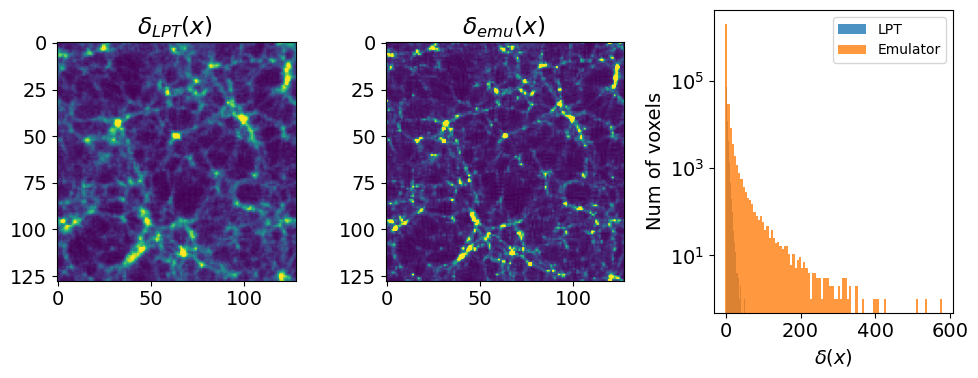

In [123]:
standard_plot(h=4)

plt.subplot(1,3,1)
plt.imshow(np.sum(delta_m[:,:,:10],axis=-1),vmax=50)
plt.title('$\delta_{LPT}(x)$ ')
plt.subplot(1,3,2)
plt.imshow(np.sum(emu_delta_m[:,:,:10]-1,axis=-1),vmax=50)
plt.title('$\delta_{emu}(x)$ ')
plt.tight_layout()
plt.subplot(1,3,3)
plt.hist(delta_m.flatten(),bins=100,label='LPT',alpha=0.8)
plt.hist((emu_delta_m-1).flatten(),bins=100,label='Emulator',alpha=0.8)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta(x)$')
plt.ylabel('Num of voxels')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## Density test

In [6]:
from jax import vjp
import jax.numpy as jnp
import numpy as np
from utils.utils import *

In [17]:
# Note need to flip positions here...! # Jens implementation .... 
delta_m2 = density(pos[:,2],pos[:,1],pos[:,0],L,N)
delta_m2.shape

cell_len =  1.953125


(128, 128, 128)

In [15]:
delta_m3, cic_grad = vjp(lambda x, y, z: jax_cic(x, y, z, N, N, N, L, L, L), pos[:, 0], pos[:, 1], pos[:, 2])

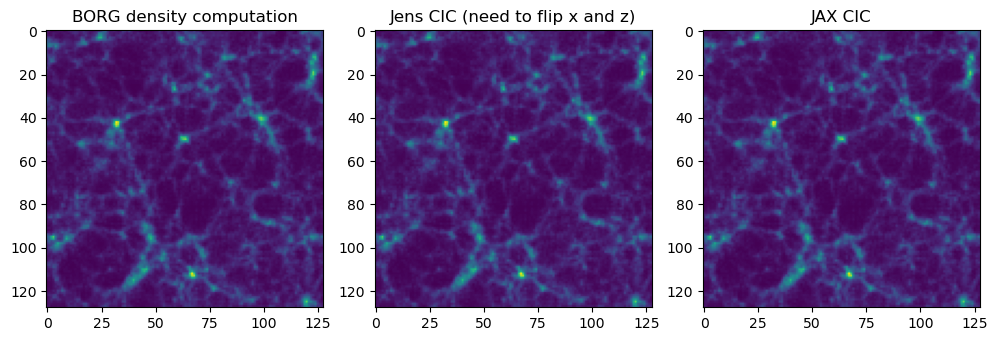

In [21]:
standard_plot(h=8,fontsize=10)

plt.subplot(1,3,1)
plt.imshow(np.sum(delta_m[:,:,:10],axis=-1))
plt.title('BORG density computation')
plt.subplot(1,3,2)
plt.imshow(np.sum(delta_m2[:,:,:10],axis=-1))
plt.title('Jens CIC (need to flip x and z)')
plt.subplot(1,3,3)
plt.imshow(np.sum(delta_m3[:,:,:10],axis=-1))
plt.title('JAX CIC')
plt.tight_layout()
plt.show()

# Integrate emu-model from Drew into BORG 

In [ ]:
# Todo:
# 1. compute_displacement much faster if we store q_v and n_v = [n1,...,nN^3]